# What is optimization and why is it important?

Fundamentally, optimization refers to taking action of making the best or most effective use of a situation or resource. In general, optimization involves maximizing or minimizing an objective function, subject to a set of constraints.

Some applications of optimization are:

- Cost reduction in supply-chain management such as cost of ingredients, storage and logistics.
- Inventory optimization to determine the ideal amount of inventory needed to satisfy customer demand without excessive production.
- Scheduling optimization of railway networks composed of busy complex stations.
- Profit maximizing on the long-term investment. 

Optimization is important in every aspect especially in business because it helps to increase the working efficiency, reduce costs, reduce wastages that ultimately can lead to higher profits. 

# What is linear programming?

Linear programming is one of the ways to perform optimization. In linear programming, the problem is formulated into a mathematical model with an objective function and a set of linear inequalities or equality constraints.

# Background

In this simplied supply chain cost management problem, we have 2 factories (i.e. <b>factoryA</b> and <b>factoryB</b>) that have to produce 2 types of breads (i.e. <b>breadA</b> and <b>breadB</b>) and supply to 3 supermarkets (i.e. <b>supermarketA</b>, <b>supermarketB</b>, and <b>supermarketC</b>).

<img src="image/background.png" width="500">

Our objective is to produce a schedule of production together with logistic status from both factories that meets the bread demands from all supermarkets with the lowest cost.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pulp

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Read Data.

In [2]:
df_demand_superA = pd.read_csv('dataset/demand_superA.csv')
df_demand_superB = pd.read_csv('dataset/demand_superB.csv')
df_demand_superC = pd.read_csv('dataset/demand_superC.csv')

df_demand_superA['supermarket'] = 'superA'
df_demand_superB['supermarket'] = 'superB'
df_demand_superC['supermarket'] = 'superC'

df_demand = pd.concat([df_demand_superA, df_demand_superB, df_demand_superC])

df_demand.set_index(keys=['month', 'supermarket'], inplace=True)
df_demand

,,breadA,breadB
month,supermarket,,
1,superA,700,620
2,superA,780,700
3,superA,730,600
4,superA,710,680
5,superA,670,790
6,superA,680,660
7,superA,690,780
8,superA,750,710
9,superA,710,700


In [3]:
df_cost_factoryA = pd.read_csv('dataset/cost_factoryA.csv')
df_cost_factoryB = pd.read_csv('dataset/cost_factoryB.csv')

# There is no info on January and February for factoryB in dataframe because it starts to operate on March.
# Add the info by ourselves.
dict_add = {'month':[1, 2], 
            'fixed_cost':[0, 0], 
            'breadA_production_cost':[0, 0],
            'breadB_production_cost':[0, 0]}

df_add = pd.DataFrame(dict_add)

df_cost_factoryB = pd.concat([df_cost_factoryB, df_add])

df_cost_factoryA['factory'] = 'factoryA'
df_cost_factoryB['factory'] = 'factoryB'

df_cost = pd.concat([df_cost_factoryA, df_cost_factoryB])

df_cost.set_index(keys=['month', 'factory'], inplace=True)
df_cost

,,fixed_cost,breadA_production_cost,breadB_production_cost
month,factory,,,
1,factoryA,5000,100,130
2,factoryA,5000,80,110
3,factoryA,5000,70,100
4,factoryA,5000,100,105
5,factoryA,5000,110,120
6,factoryA,5000,90,100
7,factoryA,5000,120,130
8,factoryA,5000,100,120
9,factoryA,5000,90,100


In [4]:
df_logistic_raw = pd.read_csv('dataset/monthly_logistic_costs.csv')
display(df_logistic_raw)

df_logistic_factoryA = (pd.melt(df_logistic_raw, id_vars =['supermarket'], value_vars =['factoryA'])
                        .rename(columns={'value':'logistic_cost'}))
df_logistic_factoryB = (pd.melt(df_logistic_raw, id_vars =['supermarket'], value_vars =['factoryB'])
                        .rename(columns={'value':'logistic_cost'}))

df_logistic_factoryA['factory'] = 'factoryA'
df_logistic_factoryB['factory'] = 'factoryB'
df_logistic_factoryA.drop('variable', axis=1, inplace=True)
df_logistic_factoryB.drop('variable', axis=1, inplace=True)

df_logistic = pd.concat([df_logistic_factoryA, df_logistic_factoryB])
df_logistic.replace('A', 'superA', inplace=True)
df_logistic.replace('B', 'superB', inplace=True)
df_logistic.replace('C', 'superC', inplace=True)

df_logistic.set_index(keys=['factory', 'supermarket'], inplace=True)
display(df_logistic)

,supermarket,factoryA,factoryB
0,A,10000,25000
1,B,40000,12000
2,C,12000,10000


logistic_cost
factory  supermarket               
factoryA superA               10000
         superB               40000
         superC               12000
factoryB superA               25000
         superB               12000
         superC               10000

### Step 1: Instantiate a problem class.

We wish to minimize the overall production costs.

In [5]:
model = pulp.LpProblem('minimize-cost', pulp.LpMinimize)

### Step 2: Model the decision variables.

We’ll need to model 2 decision variables:

1. Production: Production is modelled as an integer variable.
2. Logistic between factories and supermarket (on/off): Binary variable. It will have a value of 1 if the factory supplies to the supermarket in particular month and 0 when the factory does not supply to the supermarket.

Binary variables are the same as integer variables but constrained to be >= 0 and <=1.

In [6]:
months = df_demand.index.levels[0].tolist()
factories = df_cost.index.levels[1].tolist()
bread_types = df_demand.columns.tolist()
supermarkets = df_demand.index.levels[1].tolist()

print(months)
print(factories)
print(bread_types)
print(supermarkets)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
['factoryA', 'factoryB']
['breadA', 'breadB']
['superA', 'superB', 'superC']


In [7]:
production = pulp.LpVariable.dicts('production',
                                   ((month, factory, supermarket, bread) for month, factory in df_cost.index 
                                    for supermarket in supermarkets for bread in bread_types),
                                   lowBound=0,
                                   cat='Integer')

In [8]:
logistic_status = pulp.LpVariable.dicts('logistic_status',
                                        ((month, factory, supermarket) for month in months for factory, supermarket in df_logistic.index),
                                        lowBound=0, upBound=1, cat='Integer')

### Step 3: Add objective function.

In this simplified version, there are 3 costs incurred:

1. Fixed costs: The costs incurred as long as the factory starts to operate. For example, rental, wages and etc.
2. Production costs: The costs incurred when producing breads. It is the ingredient costs to produce each bread.
3. Logistic costs: The costs to deliver breads to supermarkets.

In [9]:
model += pulp.lpSum(
    [df_cost.loc[(month, factory), 'fixed_cost'] for month, factory in df_cost.index]
    +([production[(month, factory, supermarket, bread)]*df_cost.loc[(month, factory), f'{bread}_production_cost'] for month, factory in df_cost.index 
      for supermarket in supermarkets for bread in bread_types])
    +[logistic_status[(month, factory, supermarket)]*df_logistic.loc[(factory, supermarket), 'logistic_cost'] for month in months for factory, supermarket in df_logistic.index]
)


### Step 4: Add constraint.

1. Productions in any month must be equal to demand.
2. The factory that supplies breads to the particular supermarket must produce the required amount of breads.
3. Factory B starts to operate from March.

In [10]:
# Productions in any month must be equal to demand.
for month in range(1,13):
    for supermarket in supermarkets:
        for bread in bread_types:
        
            if month in [1, 2]:
                model += production[(month, 'factoryA', supermarket, bread)]==df_demand.loc[(month, supermarket), bread]

            else:
                model += (production[(month, 'factoryA', supermarket, bread)]+
                          production[(month, 'factoryB', supermarket, bread)]==df_demand.loc[(month, supermarket), bread])

In [11]:
# The factory that supplies breads to the particular supermarket must produce the required amount of breads.
for factory in factories:
    for month, supermarket in df_demand.index:
        for bread in bread_types:

            bread_demand = df_demand.loc[(month, supermarket), bread]

            model += (production[(month, factory, supermarket, bread)] == 
                      bread_demand * logistic_status[(month, factory, supermarket)])

In [12]:
# Factory B starts to operate from March.
model += logistic_status[1, 'factoryB', 'superA'] == 0
model += logistic_status[1, 'factoryB', 'superB'] == 0
model += logistic_status[1, 'factoryB', 'superC'] == 0

model += logistic_status[2, 'factoryB', 'superA'] == 0
model += logistic_status[2, 'factoryB', 'superB'] == 0
model += logistic_status[2, 'factoryB', 'superC'] == 0

### Step 5: Solve linear equation.

In [13]:
model.solve()
pulp.LpStatus[model.status]

'Optimal'

In [14]:
total_cost = pulp.value(model.objective)

print(f'The optimized cost is {round(total_cost, 2)}.')

The optimized cost is 5817150.0.


In [15]:
output = []

for month, factory, supermarket, bread in production:
    var_output = {
        'month': month,
        'factory': factory,
        'supermarket': supermarket,
        'bread': bread,
        'production': production[(month, factory, supermarket, bread)].varValue,
        'logistic_status': logistic_status[(month, factory, supermarket)].varValue
    }
    output.append(var_output)
    

df_output = pd.DataFrame(output)

#df_output.set_index(['month', 'factory']).sort_index()

## Visualization

In [16]:
def visualize(df1, df2, factory_title, bread_title):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

    plt.rcParams.update({'font.size': 14})    
    plt.rcParams['patch.linewidth'] = 0
    plt.rcParams['patch.edgecolor'] = 'none'
    legend_colors = []
    legend_names = []

    sns.heatmap(df1, cmap='Blues', cbar=False, annot=True, fmt='g', ax=ax[0])
    sns.heatmap(df2, cmap='Greens', cbar=False, annot=True, ax=ax[1])

    ax[0].set_title(f'Monthly Productions of {bread} in {factory}', loc='center',fontsize=15) 
    ax[0].set_xlabel(f'Productions of {bread} in supermarkets',fontsize=15)
    ax[0].set_ylabel(f'Month',fontsize=15)
    
    ax[1].set_title(f'Monthly Logistic Status of in {factory}', loc='center',fontsize=15) 
    ax[1].set_xlabel(f'Logistic Status',fontsize=15)
    ax[1].set_ylabel(f'Month',fontsize=15)
    
    plt.show()

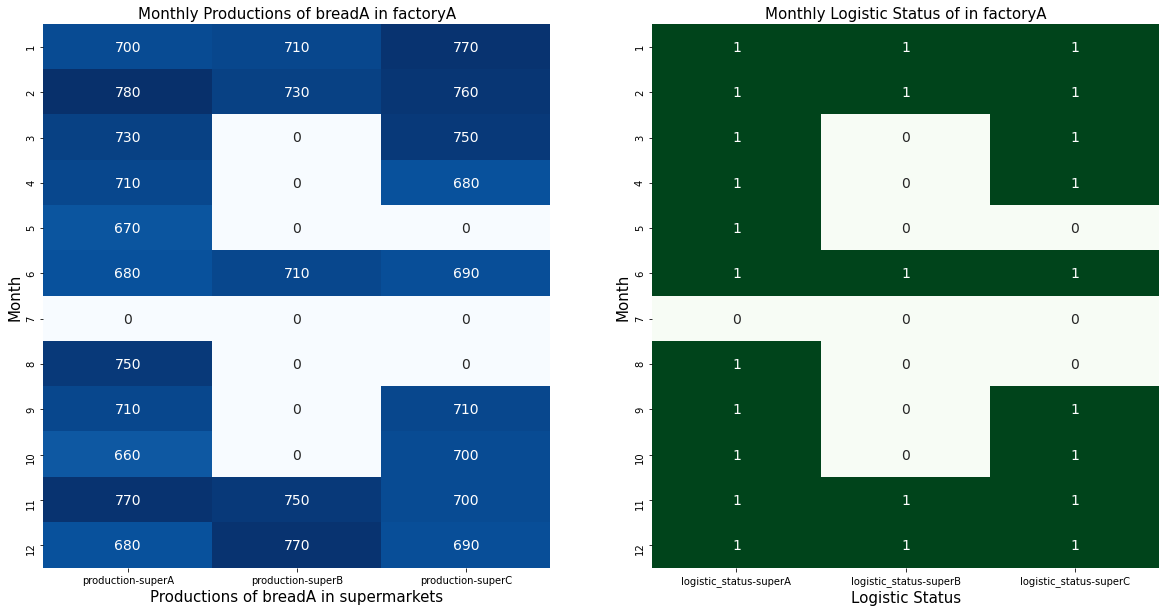

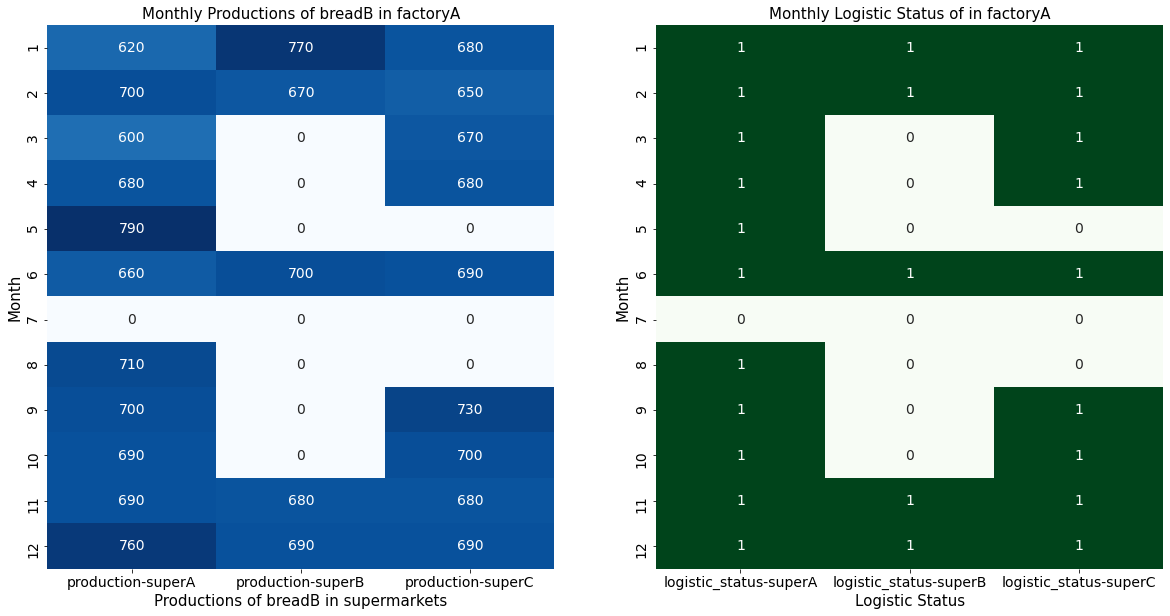

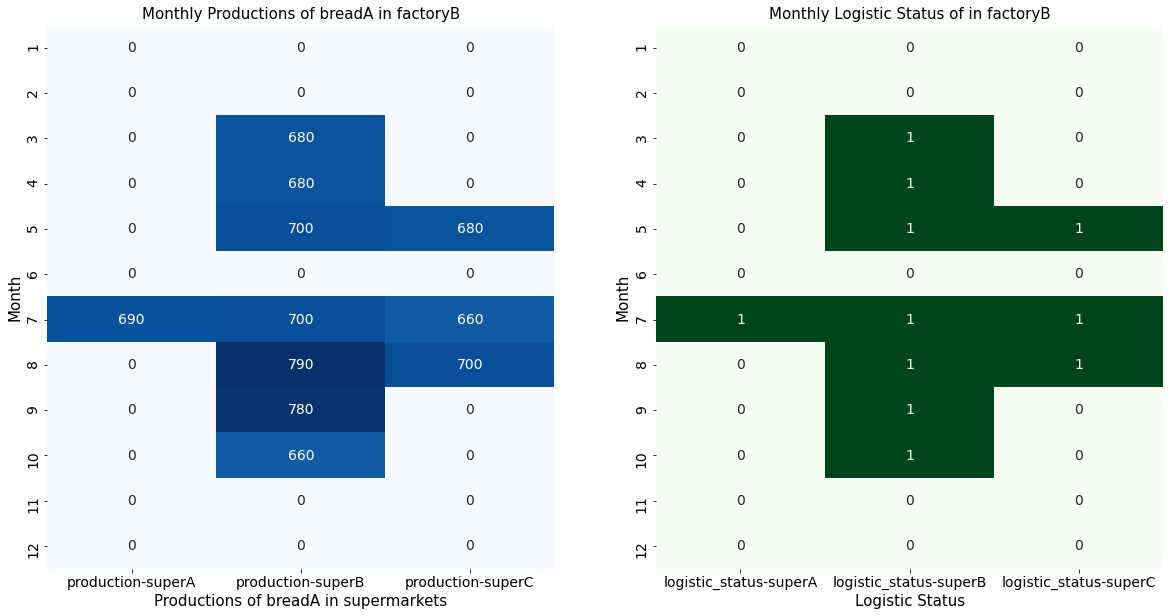

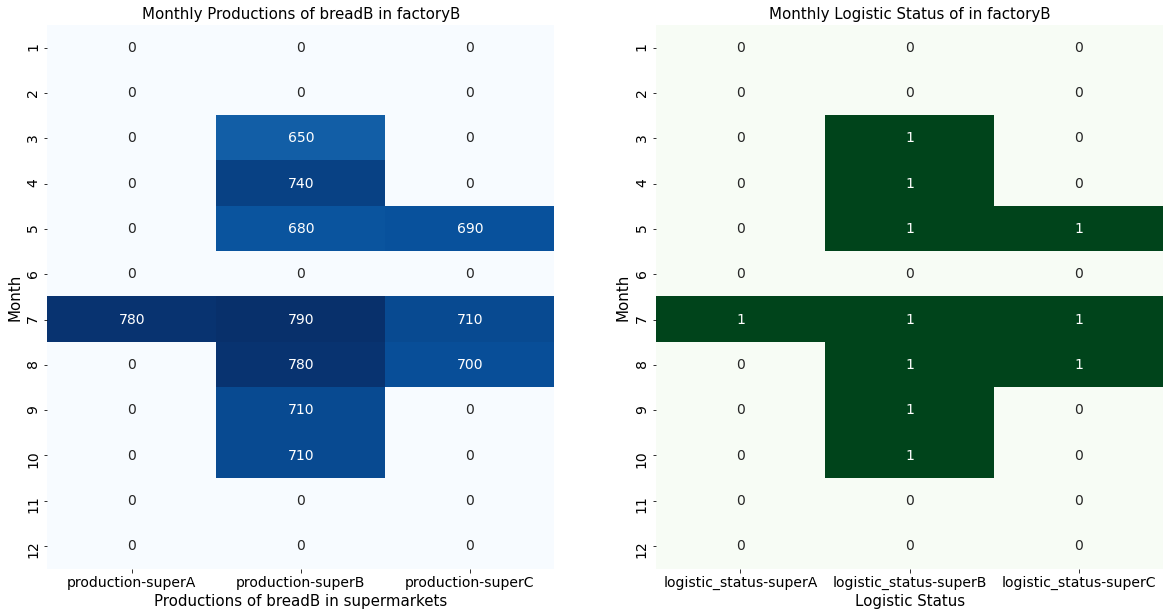

In [17]:
for factory in factories:
    
    factory_output = df_output[df_output['factory']==factory]
    
    for bread in bread_types:
        
        bread_output = factory_output[factory_output['bread']==bread]
        
        pivot_output_1 = pd.pivot_table(bread_output[['month', 'supermarket', 'production']], index='month', 
                                        columns='supermarket', aggfunc='sum')

        pivot_output_2 = pd.pivot_table(bread_output[['month', 'supermarket', 'logistic_status']], index='month', 
                                        columns='supermarket', aggfunc='sum')
        
        visualize(df1=pivot_output_1, df2=pivot_output_2, factory_title=factory, bread_title=bread)

---

## Reference

http://benalexkeen.com/linear-programming-with-python-and-pulp-part-5/